# Decision Tree Regresion for Trading


    * Retrieve market data for a financial instrument.
    * Introduce the Predictor variables (i.e. Technical indicators, Sentiment indicators, Breath indicators, etc.)
    * Setup the Target variable or the desired output.
    * Split data between training and test data.
    * Generate the decision tree training the model.
    * Make forecast.
    * Testing and analyzing the model.


In [12]:
import os
import pandas as pd
import datetime as dt
import numpy as np
from markupsafe import Markup
import fix_yahoo_finance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree, metrics, neighbors
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

from util import create_df_benchmark, fetchOnlineData, get_data, \
    symbol_to_path
from indicators import get_indicators

%matplotlib inline
import matplotlib.pyplot as plt

## Retrieve market data for a financial instrument.

In [3]:
symbol = "AABA"


# Set Forecast date
forecast_date = dt.date.today()


# Get Forecast time
forecast_time = 7

# Get Lookback
forecast_lookback = 365


# Set lookback date of data to train and test
start_d = forecast_date - dt.timedelta(forecast_lookback)
start_d = f"{start_d:%Y-%m-%d}"
yesterday = dt.date.today() - dt.timedelta(1)

In [4]:
portf_value = fetchOnlineData(start_d, symbol, yesterday)

[*********************100%***********************]  1 of 1 downloaded


## Normalize data

In [5]:
# Normalize the prices Dataframe
normed = portf_value.copy()
#normed = scaling_data(normed, symbol)

normed['date'] = portf_value.index
normed.set_index('date', inplace=True)
normed.rename(columns={'Adj Close': symbol}, inplace=True)

# Introduce the Predictor variables

In [6]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(normed, symbol)


# Create momentum column
normed['Momentum'] = sym_mom

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi_value

# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()

date
2018-02-20    0.028686
2018-02-21    0.021488
2018-02-22    0.046563
2018-02-23    0.124512
2018-02-26    0.107832
2018-02-27    0.070745
2018-02-28    0.049642
2018-03-01    0.001086
2018-03-02   -0.022984
2018-03-05   -0.000952
2018-03-06    0.007776
2018-03-07    0.011583
2018-03-08    0.002781
2018-03-09   -0.014660
2018-03-12   -0.006660
2018-03-13   -0.002102
2018-03-14    0.031396
2018-03-15    0.077027
2018-03-16    0.099188
2018-03-19    0.059913
2018-03-20    0.051882
2018-03-21    0.027507
2018-03-22   -0.015318
2018-03-23   -0.047246
2018-03-26   -0.022563
2018-03-27   -0.038700
2018-03-28   -0.059067
2018-03-29   -0.067741
2018-04-02   -0.103880
2018-04-03   -0.093911
                ...   
2018-12-19   -0.109568
2018-12-20   -0.111964
2018-12-21   -0.116807
2018-12-24   -0.104773
2018-12-26   -0.074636
2018-12-27   -0.077205
2018-12-28   -0.070268
2018-12-31   -0.065635
2019-01-02   -0.043109
2019-01-03   -0.060724
2019-01-04    0.017678
2019-01-07    0.051666
2019-0

,AABA,Momentum,SMA,RSI
date,,,,
2018-02-05,72.510002,0.000000,0.000000,58.873244
2018-02-06,73.529999,0.000000,0.000000,58.873244
2018-02-07,72.160004,0.000000,0.000000,58.873244
2018-02-08,69.150002,0.000000,0.000000,58.873244
2018-02-09,70.480003,0.000000,0.000000,58.873244
2018-02-12,71.099998,0.000000,0.000000,58.873244
2018-02-13,71.309998,0.000000,0.000000,58.873244
2018-02-14,73.660004,0.000000,0.000000,67.293118
2018-02-15,74.400002,0.000000,0.000000,69.581003


# Setup the Target variable or the desired output.

In [7]:
# Define X and y
feature_cols = ['Momentum', 'RSI']
X = normed[feature_cols]
y = normed[symbol]

# Split data between training and test data.

In [8]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

# Generate the decision tree training the model.

In [13]:
dtr = DecisionTreeRegressor(min_samples_leaf = 200)

In [14]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=200,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

## Visualize the model

In [ ]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dtr,
                  out_file=None,
                  filled=True,
                  feature_names=feature_cols)
graphviz.Source(dot_data)

# Make forecast

In [17]:
y_pred = dtr.predict(X_test)

# Testing and analizing the model

In [31]:
results = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})
results

,Price,Price prediction
date,,
2018-10-15,60.930000,72.649772
2018-10-16,62.830002,72.649772
2018-10-17,62.189999,72.649772
2018-10-18,60.060001,72.649772
2018-10-19,60.389999,72.649772
2018-10-22,62.200001,72.649772
2018-10-23,61.349998,72.649772
2018-10-24,59.070000,72.649772
2018-10-25,60.740002,72.649772


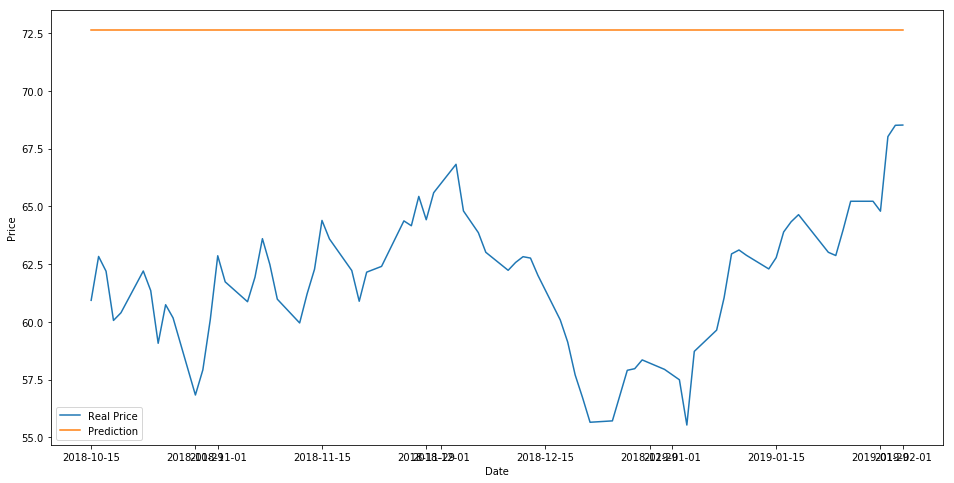

In [28]:
plt.figure(figsize=(16,8))
plt.plot(results)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

In [75]:
from sklearn.ensemble import AdaBoostRegressor


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=20)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                          n_estimators=300, random_state=0)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)



AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=0)

In [76]:
# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

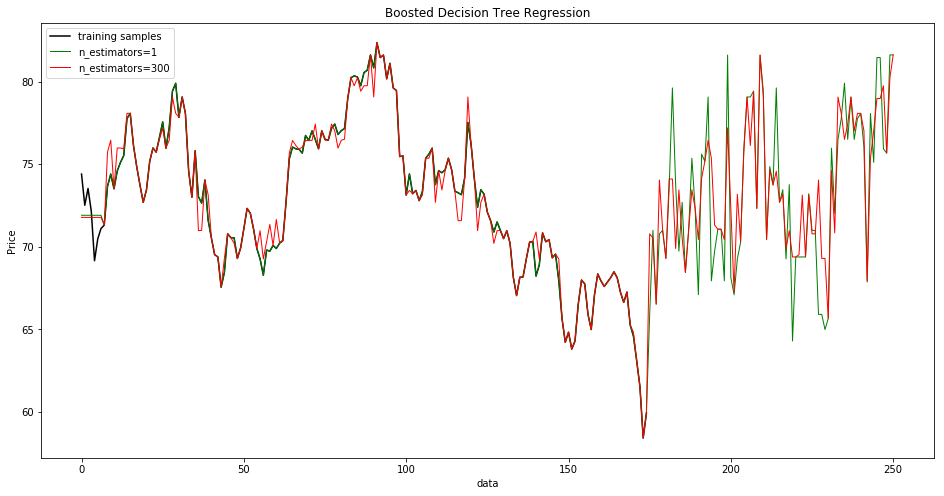

In [77]:
# Plot the results
plt.figure(figsize=(16,8))
plt.plot(y_train.values, c="k", label="training samples")
plt.plot(y_1, c="g", label="n_estimators=1", linewidth=1)
plt.plot(y_2, c="r", label="n_estimators=300", linewidth=1)
plt.xlabel("data")
plt.ylabel("Price")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()